# NDIF Main Demo Notebook

# Setup

(No need to read)

In [66]:
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # Get and unzip NDIF engine
    !wget -O ndif-dev.zip https://drive.google.com/uc?id=1jS0ydba19uPXCC786_Sx1Bylqx-p0hEc&export=download
    !unzip ndif-dev.zip

    # Install necessary libraries
    %pip install -e ndif-dev
    %pip install circuitsvis
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens

    # Upgrade pydantic 1.10.13 -> 2.4.2
    # Without it, @field_serializer isn't available Colab
    %pip install --upgrade pydantic
    
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook")

Running as a Jupyter notebook


In [22]:
import sys
sys.path.append('ndif-dev')
from engine import LanguageModel

In [2]:
import torch
import engine
import einops
import circuitsvis as cv
import plotly.express as px
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import transformers
from pathlib import Path
import numpy as np
from jaxtyping import Int, Float
from typing import List, Optional, Tuple, Union
from tqdm import tqdm
from IPython.display import display
import transformer_lens.utils as utils
import webbrowser

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [3]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [4]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

While we're at it, lets import a couple helper functions.

In [23]:
from engine.util import cross_entropy_loss
from engine.util import apply

# Introduction

This is a demo notebook for the Engine API, a service of the National Deep Inferencing Framework that provides access to the internal activations, parmeters, and gradients of open LLMs. We believe that understanding AI cognition is one of the greatest scientific questions of the age, but training itself does not yield understanding. Progress will be made through a massive public undertaking that bridges accessibility in research and experimentation, a platform democratizing transparent access to big models. 

The Engine API is a package for doing mechanistic interpretability of large models. The goal of mechanistic interpretability is to take a trained model and reverse engineer the algorithms the model learned during training from its weights. It is a fact about the world today that we have computer programs that can essentially speak English at a human level (GPT-3, PaLM, etc), yet we have no idea how they work nor how to write one ourselves. 

## Loading Models

The engine API allows you to access open source LLMs by referencing a Hugging Face repo ID. You can load any of them in with `LanguageModel(REPO_ID)`. For this demo notebook we'll look at GPT-2 Small, an 80M parameter model.

In [5]:
model = LanguageModel('gpt2',device_map=device)

To try the model out, let's generate some text!

In [6]:
with model.generate(max_new_tokens=1) as generator:
    with generator.invoke('The Eiffel Tower is in the city of') as invoker:
        hidden_states = model.transformer.h[-1].output[0].save()

output = generator.output
print([model.tokenizer.decode(t) for t in output])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['The Eiffel Tower is in the city of Paris']


Lets go over this piece by piece.

**First, we create a generation context block** by calling `.generate(...)` on the model object. This denotes that we wish to generate tokens given some prompts.
```
with model.generate(max_new_tokens=1) as generator:
```
Calling `.generate(...)` does not actually initialize or run the model. Only after the `with...generator:` block is exited is the model actually loaded and run. All operations in the block are "proxies" which essentially creates a graph of operations we wish to carry out later.

**Within the generation context,** we create invocation contexts to specify the actual prompts we want to run.
```
with generator.invoke(PROMPT) as invoker:
```
**Within an invoke context**, all operations/interventions will be applied to the processing of the prompt. Models can be run on a variety of input formats: strings, lists of tokens, tensors of tokens, etc.

Finally, we can access raw tensors and activations at any point in the model. ***But what can we do with these activations?***

## Accessing Activations

The first basic operation when doing mechanistic interpretability is to break open the black box and look at all of the internal activations of the model. Let's try this out on the first line of the GPT-2 paper.

In [7]:
gpt2_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
gpt2_tokens = model.tokenizer.encode(gpt2_text)

with model.generate(max_new_tokens=1) as generator:
    with generator.invoke(gpt2_tokens) as invoker:
        hidden_states = model.transformer.h[-1].output[0].save()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once again, we create a generate context and invoke a prompt, this time a list of tokens:
```
hidden_states = model.transformer.h[-1].output[0].save()
```
On this line we're saying: access the last layer of the transformer `model.transformer.h[-1]`, access its output `.output`, index it at 0 `.output[0]`, and save it `.save()`. To break this statement down: 

- `model.transformer.h[-1]` accesses a module in the computation graph. `.transformer.h[-1]` specifically accesses the last transformer layer.
- `.output` returns a proxy for the output of this module. In other words, when we get to the output of this module during inference, grab it and perform any operations we define on it (which also become proxies). There are two operational proxies here, one for getting the 0th index of the output, and one for saving the output. We take the 0th index because *the output of gpt2 transformer layers are a tuple* where the first index are the actual hidden states (last two indicies are from attention). 
  - `.shape` can be called on any proxy to get what shape the value will eventually be. Running `print(model.transformer.h[-1].output.shape)` returns `(torch.Size([1, 10, 768]), (torch.Size([1, 12, 10, 64]), torch.Size([1, 12, 10, 64])))`
  - ***Note:*** `.input` similarly returns a proxy for the inputs to this module. 
- `.save()` informs the computation graph to clone the value of a proxy, allowing us to access the value of a proxy after generation. During processing of the intervention computational graph we are building, when the value of a proxy is no longer ever needed, its value is dereferenced and destroyed.

After exiting the generator context, the model is ran with the specified arguments and intervention graph. `generator.output` is populated with the actual output and `hidden_states.value` will contain the value.

In [8]:
output = generator.output
hidden_states = hidden_states.value

print(output)
print(hidden_states)

tensor([[35364,  3303,  7587,  8861,    11,   884,   355,  1808, 18877,    11,
          4572, 11059,    11,  3555, 35915,    11,   290, 15676,  1634,    11,
           389,  6032, 10448,   351, 28679,  4673,   319,  8861,   431,  7790,
         40522,    13,  2102]], device='cuda:0')
tensor([[[ -0.2059,   0.1688,  -2.0503,  ...,  -0.3703,  -0.2015,  -1.6594],
         [ -3.9412,  -0.2137,  -8.5667,  ...,   6.3562,   4.1276,   3.6006],
         [ -2.0798,  -1.5781,  -6.1944,  ...,   4.8023,   5.6864,  -2.6289],
         ...,
         [ -2.1180,  -6.4320, -20.7147,  ...,   8.7145,   2.3738,   3.4004],
         [ -1.1358,  -3.9569, -20.3060,  ...,   7.1600,   1.6868,   0.9850],
         [ -1.7206,  -4.7800,  -1.1185,  ...,   3.1680,   3.7024,   0.2865]]],
       device='cuda:0')


We can see the module tree by printing the model. This lets us know what attributes access the modules we need. Run `print(model)` below to see the results.

In [ ]:
print(model)

### Visualizing Attention Heads

That was a lot, so lets put it into practice.

In [9]:
with model.generate(max_new_tokens=1) as generator:
    with generator.invoke(gpt2_tokens) as invoker:
        q  = model.transformer.h[0].attn.query.output.save()
        k  = model.transformer.h[0].attn.key.output.save()
        # Note how we save the .input to this module.
        attn_patterns = model.transformer.h[0].attn.attn_dropout.input.save()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Above, we save the the query and key values for the first layer of the model. We also save the input to the attention dropout which are the attention patterns shape `[batch head_idx seq_q seq_k]`.

Lets use q and k to create an attention pattern and verify the saved input to attention dropout.

In [10]:
q, k = q.value[0], k.value[0]
head_idx, seq_len, dim = q.shape
layer0_attn_scores = einops.einsum(
        q,k,
        "head_idx seq_q head_dim, head_idx seq_k head_dim-> head_idx seq_q seq_k"
    )

# Mask where Q > K
mask = torch.triu(torch.ones((12, seq_len, seq_len), dtype=bool), diagonal=1).to(device)
layer0_attn_scores.masked_fill_(mask, -1e9)

# Scale and softmax
layer0_pattern_from_q_and_k = (layer0_attn_scores / dim**0.5).softmax(-1)

We create a simple comparison between our calculated attention pattern and the one we saved from inference. It checks for equality between individual tensor values and returns the percentage of true values.

In [11]:
bool_matrix = layer0_pattern_from_q_and_k == attn_patterns.value[0]
num_true = bool_matrix.sum().item()

# Calculate the total number of values in the matrix
total_values = bool_matrix.numel()

# Calculate the percentage of True values
percent_true = (num_true / total_values) * 100
print(percent_true)

100.0


Nice! Now lets visualize the attention pattern of all the heads in layer 0, using [Alan Cooney's CircuitsVis library](https://github.com/alan-cooney/CircuitsVis) (based on [Anthropic's PySvelte library](https://github.com/anthropics/PySvelte)). 

This visualization is interactive! Try hovering over a token or head, and click to lock. The grid on the top left and for each head is the attention pattern as a destination position by source position grid. It's lower triangular because GPT-2 has **causal attention**, attention can only look backwards, so information can only move forwards in the network.

In [12]:
gpt2_str_tokens = [model.tokenizer.decode(i) for i in gpt2_tokens]

print("Layer 0 Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=gpt2_str_tokens,
    attention=layer0_pattern_from_q_and_k
))

Layer 0 Head Attention Patterns:


## Intervening on Activations

One of the great things about interpreting neural networks is that we have *full control* over our system. From a computational perspective, we know exactly what operations are going on inside (even if we don't know what they mean!). And we can make precise, surgical edits and see how the model's behaviour and other internals change. This is an extremely powerful tool, because it can let us set up careful counterfactuals and causal intervention to easily understand model behaviour. 

Accordingly, being able to do this is a pretty core operation, and this is one of the main things the Engine API supports! The key features here are **operation** and **setting**. Within an invoke context, most basic operations and torch operations work on proxies and are added to the computation graph. We can also use the assignment `=` operator to edit and intervene on the flow of information.

As a basic example, let's [ablate](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=fh-HJyz1CgUVrXuoiban6bYx) head 7 in layer 0 on the text above. 

We define a `.generate` context, note that this time with two invocations. Each invocation defines a separate context in which our interventions and operations do not affect other invocations. However, we can explicitly intervene cross prompt if we want to. See the [Cross Prompt Intervention](#Cross-Prompt-Intervention) in the [Features](#Features) section for more. 

Next, we intervene on the activation by accessing the attention pattern in layer 0 and setting the component with `head_index==7` to zero.

Finally, we return the `model.lm_head` for both normal and abalated contexts. The output of the language model head is logits which we can use to calculate the loss as a metric for determining the effect of our ablation intervention. 

In [74]:
layer_to_ablate = 0
head_index_to_ablate = 7

with model.generate(max_new_tokens=1) as generator:
    with generator.invoke(gpt2_tokens) as invoker:
        normal_lm_head = model.lm_head.output.save()
        
    with generator.invoke(gpt2_tokens) as invoker:
        attention_pattern = model.transformer.h[layer_to_ablate].attn.value.output
        attention_pattern[:,head_index_to_ablate,:,:] = 0. 
        abalated_lm_head = model.lm_head.output.save()

normal_lm_head = normal_lm_head.value
abalated_lm_head = abalated_lm_head.value

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [73]:
tensor_tokens = torch.tensor([gpt2_tokens]).to(device)
print(cross_entropy_loss(normal_lm_head, tensor_tokens, shift=True))
print(cross_entropy_loss(abalated_lm_head, tensor_tokens, shift=True))

tensor(4.0187)
tensor(4.2913)


### Activation Patching on the Indirect Object Identification Task

For a somewhat more involved example, let's apply **[activation patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)** on the **[Indirect Object Identification](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=iWsV3s5Kdd2ca3zNgXr5UPHa)** (IOI) task. 

The IOI task is the task of identifying that a sentence like "After John and Mary went to the store, Mary gave a bottle of milk to" continues with " John" rather than " Mary" (ie, finding the indirect object), and Redwood Research have [an excellent paper studying the underlying circuit in GPT-2 Small](https://arxiv.org/abs/2211.00593).

**[Activation patching](https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=qeWBvs-R-taFfcCq-S_hgMqx)** is a technique from [Kevin Meng and David Bau's excellent ROME paper](https://rome.baulab.info/). The goal is to identify which model activations are important for completing a task. We do this by setting up a **clean prompt** and a **corrupted prompt** and a **metric** for performance on the task. We then pick a specific model activation, run the model on the corrupted prompt, but then *intervene* on that activation and patch in its value when run on the clean prompt. We then apply the metric, and see how much this patch has recovered the clean performance. 

Here, our clean prompt is "After John and Mary went to the store, **Mary** gave a bottle of milk to", our corrupted prompt is "After John and Mary went to the store, **John** gave a bottle of milk to", and our metric is the difference between the correct logit ( John) and the incorrect logit ( Mary) on the final token. 

In [47]:
clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_tokens = model.tokenizer.encode(clean_prompt)
corrupted_tokens = model.tokenizer.encode(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    correct_index = model.tokenizer.encode(correct_answer)
    incorrect_index = model.tokenizer.encode(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

clean_resid = []

with model.generate(max_new_tokens=1) as generator:
    with generator.invoke(clean_tokens) as invoker:
        clean_logits = model.lm_head.output.save()
        for layer in range(12):
            clean_resid.append(model.transformer.h[layer].input.save())

    with generator.invoke(corrupted_tokens) as invoker:
        corrupted_logits = model.lm_head.output.save()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Note how we created a python list structure to store the residual stream input to each layer. Because we're accessing activations through **intervention proxies** within the generate context, we can't save these objects to a tensor or numpy array.

Below, we see that the logit difference is significantly positive on the clean prompt, and significantly negative on the corrupted prompt, showing that the model is capable of doing the task!

In [48]:
clean_logit_diff = logits_to_logit_diff(clean_logits.value)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits.value)
print(clean_logit_diff)
print(corrupted_logit_diff)

tensor([4.1235], device='cuda:0')
tensor([-2.2725], device='cuda:0')


Here, we'll patch in the residual stream at the start of a specific layer and at a specific position. This will let us see how much the model is using the residual stream at that layer and position to represent the key information for the task.

Note the design consideration made with respect to how the engine API performs interventions. 

We augment the tokens to a batch, shape `[seq_len, seq_len]`. By passing a batch of duplicate prompts into the model, the shape of the residual stream is now `[batch seq_len d_model]` rather than `[1 seq_len d_model]`. Within the context, we loop through the `batch` dimension and patch each respective position in the sequence. 

*Compare* this to a nested for loop that calls the generate context `layer × seq_len` times. Because the model is only run after the generate context is exited, a nested for loop would run 180 model calls versus 12.

In [71]:
seq_len = len(corrupted_tokens)
n_layers = 12
results = []
corrupted_tokens_list = [corrupted_tokens for i in range(seq_len)]

for layer in tqdm(range(n_layers)):
    with model.generate(max_new_tokens=1) as generator:
        with generator.invoke(corrupted_tokens_list) as invoker:
            resid_pre = model.transformer.h[layer].input[0]
            # Iterate through the batch dimension
            for pos in range(seq_len):
                # Get saved clean residuals
                clean_resid_pre = clean_resid[layer].value[0][:,pos,:]
                resid_pre[pos, pos, :] = clean_resid_pre
    
            patched_logits = model.lm_head.output
            results.append(patched_logits.save())

100%|██████████| 12/12 [00:16<00:00,  1.35s/it]


We can now visualize the results, and see that this computation is extremely localised within the model. Initially, the second subject (Mary) token is all that matters (naturally, as it's the only different token), and all relevant information remains here until heads in layer 7 and 8 move this to the final token where it's used to predict the indirect object.
(Note - the heads are in layer 7 and 8, not 8 and 9, because we patched in the residual stream at the *start* of each layer)

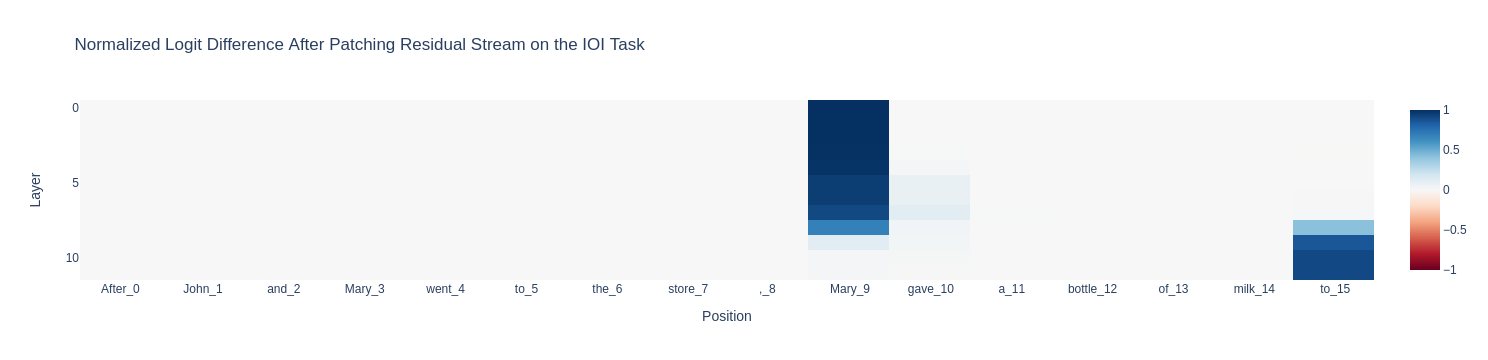

In [72]:
patched_results = np.zeros((12,16))

def patching_result(patched_logit_diff):
    return (patched_logit_diff - corrupted_logit_diff)/(clean_logit_diff - corrupted_logit_diff)

for layer in range(12):
    for pos in range(16):
        patched_results[layer, pos] = patching_result(logits_to_logit_diff(results[layer].value[pos].unsqueeze(0)))

# Add the index to the end of the label, because plotly doesn't like duplicate labels
token_labels = [f"{token}_{index}" for index, token in enumerate([model.tokenizer.decode(t) for t in clean_tokens])]
imshow(patched_results, x=token_labels, xaxis="Position", yaxis="Layer", title="Normalized Logit Difference After Patching Residual Stream on the IOI Task")

### Searching for Induction Heads

Let's look for **[induction heads](https://transformer-circuits.pub/2022/in-context-learning-and-induction-heads/index.html)** in GPT-2 Small. 

Induction circuits are a very important circuit in generative language models, which are used to detect and continue repeated subsequences. They consist of two heads in separate layers that compose together, a **previous token head** which always attends to the previous token, and an **induction head** which attends to the token *after* an earlier copy of the current token. 

To see why this is important, let's say that the model is trying to predict the next token in a news article about Michael Jordan. The token " Michael", in general, could be followed by many surnames. But an induction head will look from that occurence of " Michael" to the token after previous occurences of " Michael", ie " Jordan" and can confidently predict that that will come next.

An interesting fact about induction heads is that they generalise to arbitrary sequences of repeated tokens. We can see this by generating sequences of 50 random tokens, repeated twice, and plotting the average loss at predicting the next token, by position. We see that the model goes from terrible to very good at the halfway point.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


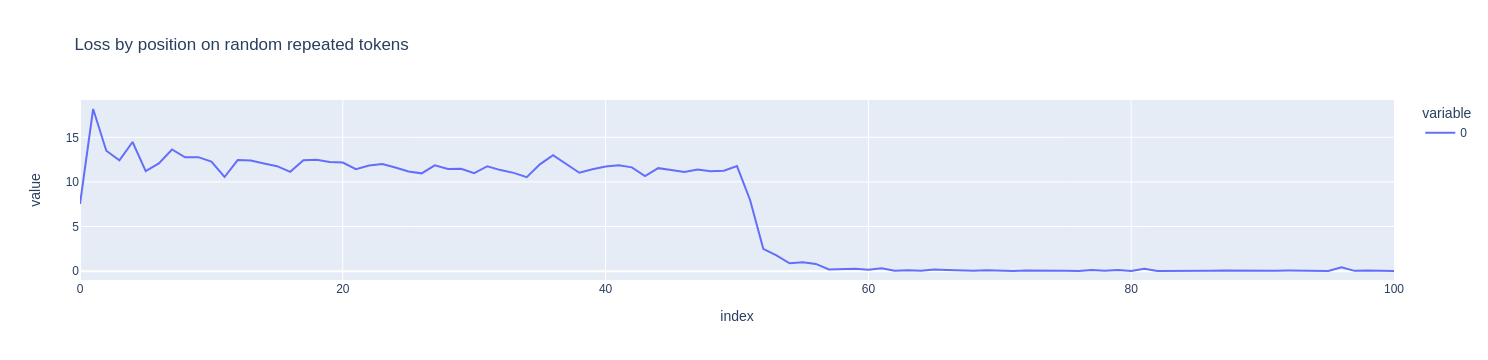

In [61]:
batch_size = 10
seq_len = 50
random_tokens = torch.randint(1000, 10000, (batch_size, seq_len))
repeated_tokens = einops.repeat(random_tokens, "batch seq_len -> batch (2 seq_len)")

with model.generate(max_new_tokens=1) as generator:
    with generator.invoke(repeated_tokens) as invoker:
        token_ids = invoker.ids
        logits = model.lm_head.output.save()

loss = cross_entropy_loss(logits.value, token_ids, shift=True, avg_token=False)
line(loss, xaxis="Position", yaxis="Loss", title="Loss by position on random repeated tokens")

The induction heads will be attending from the second occurence of each token to the token *after* its first occurence, ie the token `50-1==49` places back. So by looking at the average attention paid 49 tokens back, we can identify induction heads!

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


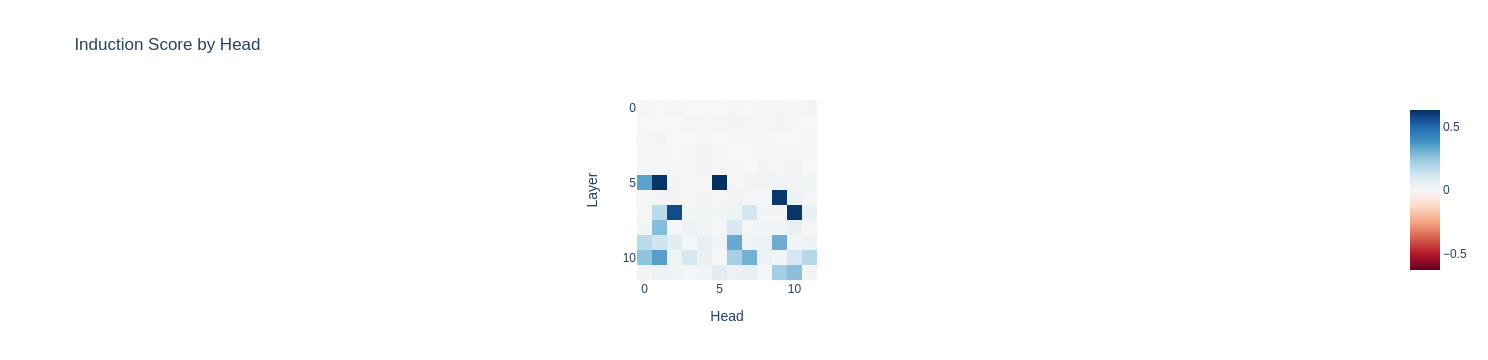

In [62]:
with model.generate(max_new_tokens=1, output_attentions=True) as generator:

    with generator.invoke(repeated_tokens, output_attentions=True) as invoker:

        attn_hidden_states = [model.transformer.h[layer_idx].attn.output[2].save() for layer_idx in range(len(model.transformer.h))]

attn_hidden_states = torch.stack([hs.value for hs in attn_hidden_states]).diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
induction_score = attn_hidden_states.mean(1).mean(-1).cpu()

imshow(induction_score, xaxis="Head", yaxis="Layer", title="Induction Score by Head")

Head 5 in Layer 5 scores extremely highly on this score, and we can feed in a shorter repeated random sequence, visualize the attention pattern for it and see this directly - including the "induction stripe" at `seq_len-1` tokens back.

In [64]:
induction_head_layer = 5
induction_head_index = 5
single_random_sequence = torch.randint(1000, 10000, (1, 20))
repeated_random_sequence = einops.repeat(single_random_sequence, "batch seq_len -> batch (2 seq_len)")

with model.generate(max_new_tokens=1, output_attentions=True) as generator:
    with generator.invoke(repeated_random_sequence, output_attentions=True) as invoker:
        attn_hidden_states = model.transformer.h[induction_head_layer].attn.output[2][:, induction_head_index].save()

cv.attention.attention_patterns(
            tokens=invoker.tokens, 
            attention=attn_hidden_states.value
        )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Features

An overview of some other important features of the library.

## Multiple Token Generation

When generating more than one token, use `invoker.next()` to denote following interventions should be applied to the subsequent generations.

Here we again generate using gpt2, but generate three tokens and save the hidden states of the last layer for each one:

In [213]:
with model.generate(max_new_tokens=3) as generator:
    with generator.invoke('The Eiffel Tower is in the city of') as invoker:

        hidden_states1 = model.transformer.h[-1].output[0].save()

        invoker.next()
        
        hidden_states2 = model.transformer.h[-1].output[0].save()

        invoker.next()
        
        hidden_states3 = model.transformer.h[-1].output[0].save()


output = generator.output
hidden_states1 = hidden_states1.value
hidden_states2 = hidden_states2.value
hidden_states3 = hidden_states3.value

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Token Based Indexing

When indexing hidden states for specific tokens, use `.token[<idx>]` or `.t[<idx>]`. This is because if there are multiple invocations, padding is performed on the left side so these helper functions index from the back.

Here we just get the hidden states of the first token:

In [212]:
with model.generate(max_new_tokens=1) as generator:
    with generator.invoke('The Eiffel Tower is in the city of') as invoker:

        hidden_states = model.transformer.h[-1].output[0].t[0].save()

output = generator.output
hidden_states = hidden_states.value

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Cross Prompt Intervention

Intervention operations work cross prompt! Use two invocations within the same generation block and operations can work between them.

In this case, we grab the token embeddings coming from the first prompt, `"Madison square garden is located in the city of New"` and replace the embeddings of the second prompt with them.

In [209]:
with model.generate(max_new_tokens=3) as generator:
    
    with generator.invoke("Madison square garden is located in the city of New") as invoker:

        embeddings = model.transformer.wte.output

    with generator.invoke("_ _ _ _ _ _ _ _ _ _") as invoker:

        model.transformer.wte.output = embeddings

print(model.tokenizer.decode(generator.output[0]))
print(model.tokenizer.decode(generator.output[1]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Madison square garden is located in the city of New York City.
_ _ _ _ _ _ _ _ _ _ York City.


We also could have entered a pre-saved embedding tensor as shown here:

In [210]:
with model.generate(max_new_tokens=3) as generator:
    
    with generator.invoke("Madison square garden is located in the city of New") as invoker:

        embeddings = model.transformer.wte.output.save()

print(model.tokenizer.decode(generator.output[0]))
print(embeddings.value)

with model.generate(max_new_tokens=3) as generator:

    with generator.invoke("_ _ _ _ _ _ _ _ _ _") as invoker:

        model.transformer.wte.output = embeddings.value

print(model.tokenizer.decode(generator.output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Madison square garden is located in the city of New York City.
tensor([[[-0.0063, -0.1795,  0.2060,  ...,  0.1978,  0.1870, -0.1588],
         [-0.1256, -0.0201,  0.0853,  ...,  0.0117, -0.1322, -0.0054],
         [ 0.1283, -0.1087,  0.1027,  ..., -0.0407, -0.1525, -0.1283],
         ...,
         [ 0.0030,  0.0874,  0.1263,  ..., -0.0033,  0.1747, -0.0309],
         [-0.0572,  0.0183,  0.0333,  ..., -0.0689, -0.0931, -0.0714],
         [-0.1341, -0.0436,  0.2236,  ..., -0.1965,  0.0693, -0.1080]]],
       device='cuda:0')


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


_ _ _ _ _ _ _ _ _ _ York City.


## Ad-Hoc Module

Another thing we can do is apply modules in the model's module tree at any point during computation, even if it's out of order.

Here we get the hidden states of the last layer like usual. We also chain apply `model.transformer.ln_f` and `model.lm_head` in order to "decode" the hidden states into vocabularly space. Applying softmax and then argmax allows us to then transform the vocabulary space hidden states into actually tokens which we can then use the tokenizer to decode.

In [211]:
with model.generate() as generator:
    with generator.invoke('The Eiffel Tower is in the city of') as invoker:
        
        hidden_states = model.transformer.h[-1].output[0]
        hidden_states = model.lm_head(model.transformer.ln_f(hidden_states)).save()
        tokens = torch.softmax(hidden_states, dim=2).argmax(dim=2).save()
        
print(hidden_states.value)
print(tokens.value)
print(model.tokenizer.decode(tokens.value[0]))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[[ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5163,  -41.3759,
           -34.9193],
         [ -68.8886,  -70.1562,  -71.8408,  ...,  -80.4195,  -78.2552,
           -71.1206],
         [ -82.2950,  -81.6519,  -83.9941,  ...,  -94.4878,  -94.5194,
           -85.6998],
         ...,
         [-113.8675, -111.8628, -113.6634,  ..., -116.7652, -114.8267,
          -112.3621],
         [ -81.8531,  -83.3006,  -91.8192,  ...,  -92.9943,  -89.8382,
           -85.6898],
         [-103.9307, -102.5054, -105.1563,  ..., -109.3099, -110.4195,
          -103.1395]]], device='cuda:0')
tensor([[ 198,   12,  417, 8765,  318,  257,  262, 3504, 7372, 6342]],
       device='cuda:0')

-el Tower is a the middle centre Paris


/home/juang.c/miniconda3/envs/interp/lib/python3.8/site-packages/transformers/generation/utils.py:1260: UserWarning:

Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.

